In [218]:
from pycaret.time_series import *
import pandas as pd

df = pd.read_csv("province/data_eng_day.csv", parse_dates=["timestamp"], index_col="timestamp")
df.index = df.index.normalize()
df = df.drop(columns=["Unnamed: 0"])

print(df.index.duplicated().sum())  # นับจำนวน index ที่ซ้ำกัน
print(df.index[df.index.duplicated()])  # แสดงค่าที่ซ้ำ
df = df[~df.index.duplicated(keep="last")]
df = df.asfreq("D")  # ตั้งค่าความถี่เป็นรายวัน
df = df.interpolate()


# แปลงคอลัมน์ timestamp ให้เป็น DatetimeIndex หากยังไม่ได้ทำ
df.index = pd.to_datetime(df.index)
# ตรวจสอบให้แน่ใจว่าไม่มีคอลัมน์ที่ไม่ต้องการ
df = df[['pm_2_5', 'humidity', 'pm_10', 'temperature']]  # ใช้เฉพาะคอลัมน์ที่ต้องการ

# ลองเรียกใช้งาน setup อีกครั้ง
train_size = int(len(df))-7
train_df = df.iloc[:train_size]  # ใช้ข้อมูลก่อนหน้าทั้งหมดเป็น train set
test_df = df.iloc[train_size:]  
train_df.index = train_df.index.to_period("D")
test_df.index = test_df.index.to_period("D")
print(len(train_df), len(test_df))

1
DatetimeIndex(['2025-02-11'], dtype='datetime64[ns]', name='timestamp', freq=None)
676 7


In [219]:
from pycaret.time_series import TSForecastingExperiment
s = TSForecastingExperiment()


target = 'pm_2_5'
print(train_df["pm_2_5"])





timestamp
2023-04-01     4.727273
2023-04-02     9.656243
2023-04-03    14.585213
2023-04-04    11.938022
2023-04-05    10.733566
                ...    
2025-01-31    24.003417
2025-02-01    31.669725
2025-02-02    32.655212
2025-02-03    35.094660
2025-02-04    24.459172
Freq: D, Name: pm_2_5, Length: 676, dtype: float64


In [220]:
df.tail(10)

,pm_2_5,humidity,pm_10,temperature
timestamp,,,,
2025-02-02,32.655212,70.341639,37.697595,27.683890
2025-02-03,35.094660,65.114261,39.898058,28.644544
2025-02-04,24.459172,70.266522,28.523077,27.775432
2025-02-05,13.987089,71.500943,16.699531,28.327450
2025-02-06,19.454865,69.511783,23.709261,28.579177
2025-02-07,29.321219,70.933952,34.743259,28.271927
2025-02-08,26.000000,69.348548,30.654249,28.385596
2025-02-09,24.616898,69.916384,28.971065,28.373742
2025-02-10,25.856981,71.226336,30.652667,28.251201


In [221]:

features = ['humidity', 'pm_10', 'temperature']  # ฟีเจอร์ที่เราจะพยากรณ์


future_exog = pd.DataFrame(index=test_df.index)
# สร้างโมเดล ARIMA สำหรับแต่ละฟีเจอร์
for feature in features:
    # เรียก setup() โดยใช้ train_df
    exp = setup(data=train_df[feature],fh=7, session_id=123, fold_strategy='rolling',seasonal_period=12, use_gpu=True)

    
    # สร้างโมเดล ARIMA
    model = create_model('arima')
    tune = tune_model(model,optimize= "R2", n_iter=30)
    # print(predict_model(model))/////////////////////////////////////
    final = finalize_model(tune)
    # print(final)
    # best = finalize_model(model)
    # print(best,X=train_df)
    # ทำนายอนาคต
    future_predictions = predict_model(final, fh=len(test_df))
    print(future_predictions)
    
    # บันทึกผลลัพธ์ลงใน future_exog
    future_exog[feature] = future_predictions['y_pred'].values

# แสดงผลลัพธ์
print(future_exog)



,Description,Value
0,session_id,123
1,Target,humidity
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(676, 1)"
5,Transformed data shape,"(676, 1)"
6,Transformed train set shape,"(669, 1)"
7,Transformed test set shape,"(7, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Th

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-07,1.1645,1.0168,6.0678,7.2205,0.0805,0.0789,-1.1246
1,2025-01-14,1.5654,1.4292,8.1814,10.1586,0.0960,0.1035,-2.0055
2,2025-01-21,1.2338,1.1616,6.4863,8.3025,0.0841,0.0809,-2.7152
Mean,NaT,1.3212,1.2026,6.9118,8.5605,0.0869,0.0878,-1.9484
SD,NaT,0.1750,0.1708,0.9138,1.2133,0.0066,0.0112,0.6506


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-07,0.5735,0.5689,2.9886,4.0398,0.0386,0.0389,0.3349
1,2025-01-14,1.0252,0.8924,5.3579,6.3429,0.0653,0.0663,-0.1717
2,2025-01-21,0.6480,0.6501,3.4069,4.6463,0.0431,0.0432,-0.1635
Mean,NaT,0.7489,0.7038,3.9178,5.0097,0.0490,0.0495,-0.0001
SD,NaT,0.1977,0.1374,1.0325,0.9747,0.0117,0.0120,0.2369


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.9s finished


             y_pred
2025-02-05  72.1354
2025-02-06  74.2020
2025-02-07  74.7879
2025-02-08  76.4537
2025-02-09  77.6028
2025-02-10  78.6259
2025-02-11  79.3886


,Description,Value
0,session_id,123
1,Target,pm_10
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(676, 1)"
5,Transformed data shape,"(676, 1)"
6,Transformed train set shape,"(669, 1)"
7,Transformed test set shape,"(7, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Th

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-07,1.9138,1.6203,20.9120,22.9966,0.4634,0.6480,-11.2162
1,2025-01-14,0.6375,0.6640,7.0599,9.5428,0.2883,0.2212,0.4263
2,2025-01-21,1.5472,1.3757,17.1226,19.7386,0.7080,0.4698,-2.5997
Mean,NaT,1.3662,1.2200,15.0315,17.4260,0.4866,0.4463,-4.4632
SD,NaT,0.5365,0.4056,5.8452,5.7308,0.1721,0.1750,4.9323


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-07,0.4710,0.5202,5.1464,7.3831,0.1035,0.1127,-0.2592
1,2025-01-14,2.1388,1.8667,23.6845,26.8272,0.9702,0.5587,-3.5338
2,2025-01-21,0.9533,0.8643,10.5499,12.4014,0.3158,0.3485,-0.4210
Mean,NaT,1.1877,1.0838,13.1269,15.5372,0.4632,0.3400,-1.4046
SD,NaT,0.7008,0.5712,7.7844,8.2419,0.3688,0.1822,1.5070


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  67 out of  90 | elapsed:   10.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   20.0s finished


             y_pred
2025-02-05  28.5231
2025-02-06  28.5231
2025-02-07  28.5231
2025-02-08  28.5231
2025-02-09  28.5231
2025-02-10  28.5231
2025-02-11  28.5231


,Description,Value
0,session_id,123
1,Target,temperature
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(676, 1)"
5,Transformed data shape,"(676, 1)"
6,Transformed train set shape,"(669, 1)"
7,Transformed test set shape,"(7, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Th

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-07,0.8286,0.7691,1.2255,1.5504,0.0463,0.0447,-0.3301
1,2025-01-14,1.1885,1.0677,1.7552,2.1478,0.0677,0.0644,-3.3043
2,2025-01-21,0.9628,0.8531,1.4274,1.7198,0.0513,0.0530,-7.7435
Mean,NaT,0.9933,0.8966,1.4694,1.8060,0.0551,0.0540,-3.7926
SD,NaT,0.1485,0.1257,0.2183,0.2514,0.0092,0.0081,3.0461


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-07,0.5732,0.5785,0.8478,1.1662,0.0322,0.0313,0.2475
1,2025-01-14,0.5427,0.4893,0.8015,0.9843,0.0303,0.0301,0.0960
2,2025-01-21,0.4530,0.3811,0.6716,0.7683,0.0242,0.0244,-0.7451
Mean,NaT,0.5230,0.4830,0.7736,0.9729,0.0289,0.0286,-0.1339
SD,NaT,0.0510,0.0807,0.0746,0.1626,0.0034,0.0030,0.4366


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  67 out of  90 | elapsed:   10.1s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.1s finished


             y_pred
2025-02-05  27.4066
2025-02-06  27.1786
2025-02-07  27.1716
2025-02-08  26.9749
2025-02-09  26.9390
2025-02-10  26.9378
2025-02-11  26.7141
            humidity    pm_10  temperature
timestamp                                 
2025-02-05   72.1354  28.5231      27.4066
2025-02-06   74.2020  28.5231      27.1786
2025-02-07   74.7879  28.5231      27.1716
2025-02-08   76.4537  28.5231      26.9749
2025-02-09   77.6028  28.5231      26.9390
2025-02-10   78.6259  28.5231      26.9378
2025-02-11   79.3886  28.5231      26.7141


In [222]:
train_df

,pm_2_5,humidity,pm_10,temperature
timestamp,,,,
2023-04-01,4.727273,73.861694,4.727273,30.189449
2023-04-02,9.656243,70.867094,10.386819,30.042296
2023-04-03,14.585213,67.872493,16.046366,29.895143
2023-04-04,11.938022,62.995952,13.300139,33.853401
2023-04-05,10.733566,59.482051,11.864336,35.772219
...,...,...,...,...
2025-01-31,24.003417,68.520368,28.628702,27.336718
2025-02-01,31.669725,69.231031,36.793578,27.315410
2025-02-02,32.655212,70.341639,37.697595,27.683890


In [ ]:

exp = setup(data=train_df,target=target,fh=7, session_id=123, fold_strategy="rolling",seasonal_period=12, use_gpu=True)
model = create_model('arima')
best = tune_model(model,optimize= "R2", n_iter=20)
future_predictions = predict_model(best, fh=len(test_df),X=future_exog)
print(future_predictions)

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(676, 4)"
5,Transformed data shape,"(676, 4)"
6,Transformed train set shape,"(669, 4)"
7,Transformed test set shape,"(7, 4)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Th

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-07,0.0532,0.0583,0.5167,0.7340,0.0133,0.0134,0.9840
1,2025-01-14,0.0935,0.0905,0.9212,1.1546,0.0448,0.0430,0.9909
2,2025-01-21,0.0995,0.0948,0.9800,1.2084,0.0426,0.0410,0.9841
Mean,NaT,0.0821,0.0812,0.8060,1.0323,0.0336,0.0325,0.9864
SD,NaT,0.0206,0.0163,0.2059,0.2121,0.0144,0.0135,0.0032


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-07,0.0380,0.0394,0.3696,0.4958,0.0094,0.0095,0.9927
1,2025-01-14,0.0995,0.0818,0.9800,1.0432,0.0417,0.0407,0.9926
2,2025-01-21,0.0516,0.0511,0.5081,0.6508,0.0187,0.0184,0.9954
Mean,NaT,0.0630,0.0574,0.6192,0.7299,0.0233,0.0229,0.9936
SD,NaT,0.0264,0.0179,0.2613,0.2303,0.0136,0.0131,0.0013


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   29.1s finished


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ARIMA,0.4286,0.4393,4.2510,5.6358,0.1350,0.1506,-0.5291


             y_pred
2025-01-29  24.3652
2025-01-30  24.4594
2025-01-31  24.8586
2025-02-01  24.8157
2025-02-02  24.6565
2025-02-03  24.8587
2025-02-04  24.9034


In [224]:
final_best = finalize_model(best)

In [225]:

predictions_future = predict_model(final_best,X=future_exog)
predictions_future

,y_pred
2025-02-05,24.7332
2025-02-06,24.7574
2025-02-07,24.7931
2025-02-08,25.0008
2025-02-09,24.8469
2025-02-10,24.7855
2025-02-11,24.6925


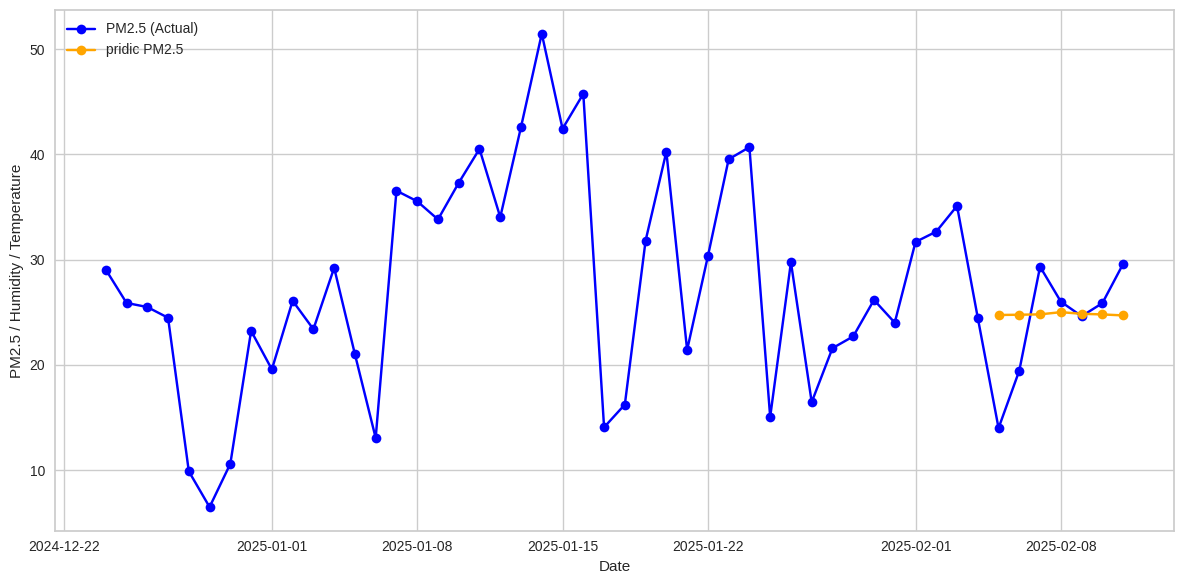

In [226]:
import matplotlib.pyplot as plt

# สร้าง figure และแกน Y แรก
fig, ax1 = plt.subplots(figsize=(12, 6))

# พลอตข้อมูลจาก df บนแกน Y แรก
ax1.plot(df.index[-50:], df['pm_2_5'][-50:], label='PM2.5 (Actual)', color='blue', linestyle='-', marker='o')
# ax1.plot(df.index, df['humidity'], label='Humidity', color='green', linestyle='-', marker='s')
ax1.plot(predictions_future.index,predictions_future, label='pridic PM2.5', color='orange', linestyle='-', marker='o')

# ตั้งค่าแกน Y แรก
ax1.set_xlabel('Date')
ax1.set_ylabel('PM2.5 / Humidity / Temperature')
ax1.tick_params(axis='y')

# สร้างแกน Y ที่สอง
# ax2 = ax1.twinx()

# พลอตข้อมูลจริงและข้อมูลที่ทำนายบนแกน Y ที่สอง
# ax1.plot(actual_values.index, predictions_future, label='Actual PM2.5', color='red', linestyle='--', marker='x')
# ax2.plot(predicted_values.index, predicted_values, label='Predicted PM2.5', color='purple', linestyle='--', marker='d')

# ตั้งค่าแกน Y ที่สอง
# ax2.set_ylabel('PM2.5 (Actual & Predicted)')
# ax2.tick_params(axis='y')

# เพิ่มคำอธิบายเส้น (legend)
lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 , labels1 , loc='upper left')

# เพิ่มกริด
ax1.grid(True)

# ปรับระยะห่างให้เหมาะสม
plt.tight_layout()

# แสดงกราฟ
plt.show()

In [227]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
# คำนวณค่า error metrics
# actual_values คือค่าจริงจากข้อมูลทดสอบ (ที่ในที่นี้ใช้ df)
actual_values = df['pm_2_5'][-len(predictions_future):]

# predicted_values คือค่าทำนายจาก model
predicted_values = predictions_future['y_pred']

# คำนวณค่า error
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

# แสดงผลลัพธ์
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 3.9675289285714292
Mean Squared Error (MSE): 27.180361639976688
Root Mean Squared Error (RMSE): 5.213478842383144
R-squared (R2): -0.011030335803881686
